## Predicting severe crashes from DC Crash Data

In the following exercise I attempt to predict whether an accident will involve serious injuries or fatalities, using DC Crash Data.  I use two methods: Random Forest classifiers, and Logistic Regression classifiers.  I compare the scores and interpret the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

%matplotlib inline

In [2]:
df = pd.read_csv('data/cleaned_crashes.csv', low_memory=False)

### Final preparation of data for modeling
Dropping unneeded columns, and dropping rows with missing or invalid data.

In [3]:
df.drop(columns=['reportdate','streetsegid','routeid','roadwaysegid','address','ward'], inplace=True)

In [4]:
df.replace([np.inf, -np.inf], np.nan)
df.isnull().sum()
df.dropna(inplace=True)

df.date_r = df.date_r.astype('datetime64[ns]')
df.to_csv('data/random_forest_data.csv')

### Random Forest

1. clean up data (for nulls, etc.)
2. split the data (train/test)
3. create model instance
4. fit the data
5. predict and score

In [5]:
df.columns

Index(['x', 'y', 'majorinjuries_bicyclist', 'minorinjuries_bicyclist',
       'fatal_bicyclist', 'majorinjuries_driver', 'minorinjuries_driver',
       'fatal_driver', 'majorinjuries_pedestrian', 'minorinjuries_pedestrian',
       'fatal_pedestrian', 'total_vehicles', 'total_bicycles',
       'total_pedestrians', 'pedestriansimpaired', 'bicyclistsimpaired',
       'driversimpaired', 'total_taxis', 'total_government',
       'speeding_involved', 'offintersection', 'intapproachdirection',
       'ward_number', 'date_r', 'injuries_any', 'day_of_week', 'fatal',
       'ped_inj_or_fatal', 'driver_inj_or_fatal', 'bike_inj_or_fatal'],
      dtype='object')

I am pulling in the features that are most likely to successfully predict major injuries and fatalities from the crash data.  I'm selecting either my engineered features or features that came with the original dataset, but taking care to not include non-independent features.

In this pass I try to predict if there are any injuries in a crash.

In [6]:
#'speeding_involved','total_pedestrians','total_bicycles',
# 'total_vehicles','ward_number' (or x and y), and possibly impairment
feature_cols = ['speeding_involved','total_pedestrians','total_bicycles',
               'total_vehicles','ward_number','x','y', 'bicyclistsimpaired',
               'driversimpaired','pedestriansimpaired','offintersection']

X = df[feature_cols]
y = df['injuries_any']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [8]:
print(X_train.shape, y_train.shape)
y_train.describe()
print(X_train.dtypes)

(106255, 11) (106255,)
speeding_involved      float64
total_pedestrians      float64
total_bicycles           int64
total_vehicles         float64
ward_number            float64
x                      float64
y                      float64
bicyclistsimpaired       int64
driversimpaired          int64
pedestriansimpaired      int64
offintersection        float64
dtype: object


The confusion matrix shows that my ability to identify the Major Injuries/Death status is okay, but my non-major crashes are less likely to be accurately predicted.  

In [28]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

pd.crosstab(y_test, predictions, rownames=['Actual Status'], colnames=['Predicted Status'])

Predicted Status,0,1
Actual Status,,
0,9685,2346
1,618,11453


The most significant feature in the model is 'offintersection', which is the distance to the nearest intersection.  The coordinates of the crash are the only other somewhat significant indicators of outcomes, the rest of the features playing very minor roles.

In [10]:
list(zip(X_train, rfc.feature_importances_))


[('speeding_involved', 0.02740759226912431),
 ('total_pedestrians', 0.03253977588558363),
 ('total_bicycles', 0.015751622573099124),
 ('total_vehicles', 0.028571020944490533),
 ('ward_number', 0.01204930351778844),
 ('x', 0.27538965542602123),
 ('y', 0.28308772717952696),
 ('bicyclistsimpaired', 7.381932481768788e-05),
 ('driversimpaired', 0.0025576469614101067),
 ('pedestriansimpaired', 0.0003328769657547387),
 ('offintersection', 0.3222389589523835)]

In [11]:
rfc.score(X_test, y_test)

0.7340009034783918

I ran through a large range of k to identify the best number of regressors.  It tapered off around 50 with only slight improvements through 99.

In [12]:
# What's the best number of regressors?
rsq_list = []

for k in range(2, 100):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    score = rfc.score(X_test, y_test)
    rsq_list.append(score)

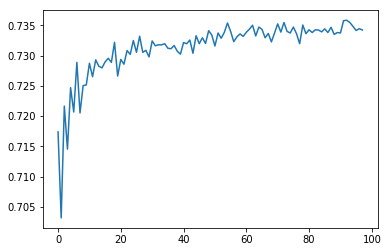

In [13]:
plt.plot(rsq_list)

In [14]:
list(zip(X_train, rfc.feature_importances_))

[('speeding_involved', 0.02713000193175587),
 ('total_pedestrians', 0.0323815051702692),
 ('total_bicycles', 0.015857310699968572),
 ('total_vehicles', 0.027656557596874094),
 ('ward_number', 0.012054664682519568),
 ('x', 0.2758732487672065),
 ('y', 0.28270320129606746),
 ('bicyclistsimpaired', 6.465886643894144e-05),
 ('driversimpaired', 0.002309687237962425),
 ('pedestriansimpaired', 0.00030538383831216274),
 ('offintersection', 0.32366377991262524)]

In [15]:
max(rsq_list)

0.7358455051950008

### Random Forest to predict major injuries or fatalities (vs minor injuries and no injuries)
Here I try to predict the major injuries and fatalities among the crash data.  I'll update my dataframe to include a field for major_fatal, to use as labels. 

In [17]:
df.columns
df['major_fatal'] = 0
df.loc[((df.majorinjuries_bicyclist>0) | (df.fatal_bicyclist>0) | 
        (df.majorinjuries_driver>0) | (df.fatal_driver>0) | 
        (df.majorinjuries_pedestrian>0) | (df.fatal_pedestrian>0)), 'major_fatal'] = 1

df.major_fatal.sum()

12312

In [18]:
feature_cols = ['speeding_involved','total_pedestrians','total_bicycles',
               'total_vehicles','ward_number','x','y', 'bicyclistsimpaired',
               'driversimpaired','pedestriansimpaired','offintersection']

X = df[feature_cols]
y = df['major_fatal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [19]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
pd.crosstab(y_test, predictions)

col_0,0,1
major_fatal,,
0,23691,452
1,2335,86


My model score is fairly good.  But don't be fooled by that score--the confusion matrix above clearly demonstrates that my model grossly underpredicts the minority case.  Having a strong model score is meaningless if the minority data cannot be predicted.

In [20]:
score = rfc.score(X_test, y_test)
score

0.8950835717512423

In [21]:
list(zip(X_train, rfc.feature_importances_))

[('speeding_involved', 0.013124412195222058),
 ('total_pedestrians', 0.004118930001395391),
 ('total_bicycles', 0.0020748124111666473),
 ('total_vehicles', 0.02602373202628299),
 ('ward_number', 0.013095470649802082),
 ('x', 0.29212319138728626),
 ('y', 0.29892149769549736),
 ('bicyclistsimpaired', 0.00030215648277789046),
 ('driversimpaired', 0.0015348512028900065),
 ('pedestriansimpaired', 0.0005029122886453714),
 ('offintersection', 0.3481780336590342)]

### Artificial Subsampling

We saw that the score above, predicting accidents with major injuries or fatalities, was very good at 0.895.  However, the associated confusion matrix indicates that our model predicted very few of the actual major injury/fatal accidents (86 of 2335), so it was actually not a good model.  Far fewer than the lower-scoring limited feature_columns dataset (score 0.734, but predicting 1543 of 5135 major/fatal accidents).  

I'll try to better train the model by upsampling the training set to balance the major/fatal incidences with the non-major/non-fatal accidents.  I'll select random samples from each category and use these as my training data.  I'll also reduce my testing data ratio to 10%, to allow more data on which to train.

References: https://elitedatascience.com/imbalanced-classes, 

In [22]:
df[df.major_fatal == 1].shape[0] / df[df.major_fatal == 0].shape[0]
#df.sample()
majors = df.loc[df.major_fatal == 1]
low_injuries = df.loc[df.major_fatal == 0]
low_injuries.shape

#majors.sample(11000)
#low_injuries.sample(20000)

(120507, 31)

Resize my minority class (major injuries or fatalities) to equal the size of my majority class.  I'll resample with replacement to achieve this, getting 120,507 samples.

In [23]:

df_majors_upsampled = resample(majors, replace=True, n_samples=120507, random_state=42)
df_upsampled = pd.concat([df_majors_upsampled, low_injuries])

### Improving results with upsampled minority data

Below I re-run the random forest classification model, using the upsampled data (in which major injury/fatal accidents occur as often as the non-injury/minor-injury accidents).  

Accuracy scoring is decreased slightly from 0.895 to 0.871, but the confusion matrix is tremendously improved, from 0.98% accuracy non-major and 4% accuracy major/fatal, to 74% accuracy non-major and 95% accuracy major/fatal accidents.


In [24]:
X = df_upsampled[feature_cols]
y = df_upsampled.major_fatal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
pd.crosstab(y_test, predictions)

col_0,0,1
major_fatal,,
0,9679,2352
1,613,11458


In [25]:
rfc.score(X_test, y_test)

0.8769811633889304

### Logistic Regression

I'll also attempt a classification using logistic regression.  I'll use the same up-sampled data from above and compare the scores.  As I feared, the score is quite weak, even with an upsampled minority class.  

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
lr.score(X_test, y_test)


0.5521118579371006

In [27]:

kfold = model_selection.KFold(n_splits=10, random_state=42)
model = LogisticRegression()
result = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
result.mean()

0.5467701191988019

### Assessment of modeling

I attempted classification modeling to identify whether a crash involved major injories or fatalities or not.  I used random forest classifiers as well as a logistic regression model with 10-fold cross-validation.  

Knowing that my data correlations were all quite weak, I did not expect very strong results.  The logistic regression returned very weak ability to identify the status of crash outcomes.  

The Random Forest classification returned much better ability to classify outcomes, but only after I significantly upsampled the minority class.  

I found that the most important features were all geographical in nature, the most significant being proximity to nearest intersection.  

### Ongoing research opportunities

Gaining access to data on the following fields will improve the accuracy of the models:  
* the number of lanes of traffic
* street speed limits by streetsegid or by latitude and longitude coordinates
* whether on-street parking was present
* accident timestamps

This data set appears to be not fully representative of all crash data in the DC metro area, but rather a subset.  Further, the data appears to be the combination of at least two collection systems of data, and due to many missing fields from one of the contributing data collections, I had to remove those rows from my analysis, resulting in a ~20% loss of overall data.  If it is available, I recommend appending the missing data to the current set.

Most importantly, I recommend work to identify all of the intersections with acute angles, and add fields to indicate the angle of the nearest intersection to each observation.  It appears from EDA that the more acute intersections are prone to a number of severe accidents, and this would lend to better predicting and avoiding serious injury or death.